<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance (2nd ed.)

**Mastering Data-Driven Finance**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

<img src="http://hilpisch.com/images/py4fi_2nd_shadow.png" width="300px" align="left">

# Model Calibration

## The Data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
import sys
sys.path.append('../')
sys.path.append('../dx')

In [4]:
dax = pd.read_csv('../../source/tr_eikon_option_data.csv',
                 index_col=0)  

In [5]:
for col in ['CF_DATE', 'EXPIR_DATE']:
    dax[col] = dax[col].apply(lambda date: pd.Timestamp(date))  

In [6]:
dax.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 114
Data columns (total 7 columns):
Instrument    115 non-null object
CF_DATE       115 non-null datetime64[ns]
EXPIR_DATE    114 non-null datetime64[ns]
PUTCALLIND    114 non-null object
STRIKE_PRC    114 non-null float64
CF_CLOSE      115 non-null float64
IMP_VOLT      114 non-null float64
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 7.2+ KB


In [7]:
dax.set_index('Instrument').head(7)  

,CF_DATE,EXPIR_DATE,PUTCALLIND,STRIKE_PRC,CF_CLOSE,IMP_VOLT
Instrument,,,,,,
.GDAXI,2018-04-27,NaT,NaN,NaN,12500.47,NaN
GDAX105000G8.EX,2018-04-27,2018-07-20,CALL,10500.0,2040.80,23.59
GDAX105000S8.EX,2018-04-27,2018-07-20,PUT,10500.0,32.00,23.59
GDAX108000G8.EX,2018-04-27,2018-07-20,CALL,10800.0,1752.40,22.02
GDAX108000S8.EX,2018-04-26,2018-07-20,PUT,10800.0,43.80,22.02
GDAX110000G8.EX,2018-04-27,2018-07-20,CALL,11000.0,1562.80,21.00
GDAX110000S8.EX,2018-04-27,2018-07-20,PUT,11000.0,54.50,21.00


In [8]:
initial_value = dax.iloc[0]['CF_CLOSE']  

In [9]:
calls = dax[dax['PUTCALLIND'] == 'CALL'].copy()  
puts = dax[dax['PUTCALLIND'] == 'PUT '].copy()  

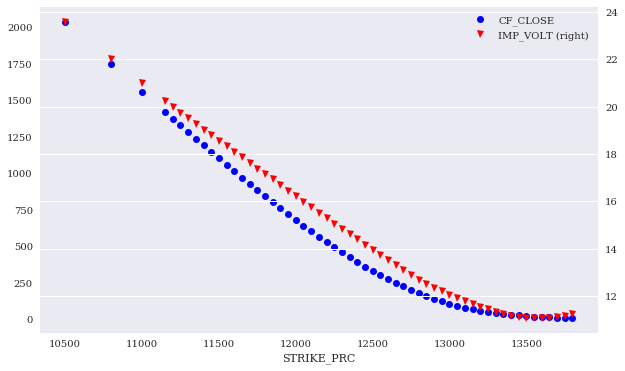

In [10]:
calls.set_index('STRIKE_PRC')[['CF_CLOSE', 'IMP_VOLT']].plot(
    secondary_y='IMP_VOLT', style=['bo', 'rv'], figsize=(10, 6));
# plt.savefig('../../images/ch21/dx_cal_01.png');

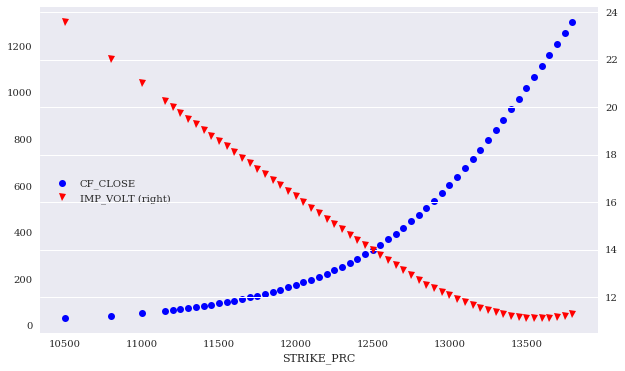

In [11]:
ax = puts.set_index('STRIKE_PRC')[['CF_CLOSE', 'IMP_VOLT']].plot(
    secondary_y='IMP_VOLT', style=['bo', 'rv'], figsize=(10, 6))
ax.get_legend().set_bbox_to_anchor((0.25, 0.5));
# plt.savefig('../../images/ch21/dx_cal_02.png');

## Model Calibration

### Relevant Market Data

In [12]:
limit = 500  

In [13]:
option_selection = calls[abs(calls['STRIKE_PRC'] - initial_value) < limit].copy()  

In [14]:
option_selection.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 43 to 81
Data columns (total 7 columns):
Instrument    20 non-null object
CF_DATE       20 non-null datetime64[ns]
EXPIR_DATE    20 non-null datetime64[ns]
PUTCALLIND    20 non-null object
STRIKE_PRC    20 non-null float64
CF_CLOSE      20 non-null float64
IMP_VOLT      20 non-null float64
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 1.2+ KB


In [15]:
option_selection.set_index('Instrument').tail()  

,CF_DATE,EXPIR_DATE,PUTCALLIND,STRIKE_PRC,CF_CLOSE,IMP_VOLT
Instrument,,,,,,
GDAX128000G8.EX,2018-04-27,2018-07-20,CALL,12800.0,182.4,12.70
GDAX128500G8.EX,2018-04-27,2018-07-20,CALL,12850.0,162.0,12.52
GDAX129000G8.EX,2018-04-25,2018-07-20,CALL,12900.0,142.9,12.36
GDAX129500G8.EX,2018-04-27,2018-07-20,CALL,12950.0,125.4,12.21
GDAX130000G8.EX,2018-04-27,2018-07-20,CALL,13000.0,109.4,12.06


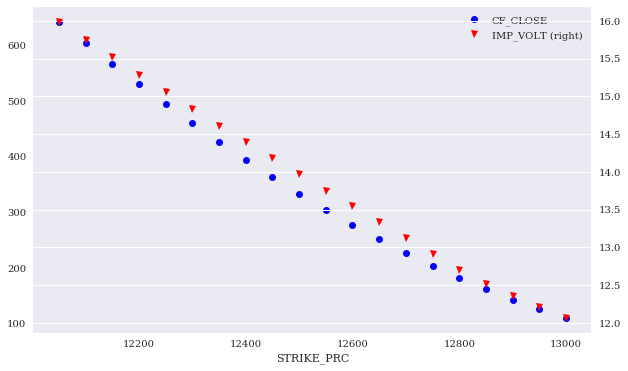

In [16]:
option_selection.set_index('STRIKE_PRC')[['CF_CLOSE', 'IMP_VOLT']].plot(
    secondary_y='IMP_VOLT', style=['bo', 'rv'], figsize=(10, 6));
# plt.savefig('../../images/ch21/dx_cal_03.png');

### Option Modeling

In [17]:
import dx

In [18]:
pricing_date = option_selection['CF_DATE'].max()  

In [19]:
me_dax = dx.market_environment('DAX30', pricing_date)  

In [20]:
maturity = pd.Timestamp(calls.iloc[0]['EXPIR_DATE'])  

In [21]:
me_dax.add_constant('initial_value', initial_value)  
me_dax.add_constant('final_date', maturity)  
me_dax.add_constant('currency', 'EUR')  

In [22]:
me_dax.add_constant('frequency', 'B')  
me_dax.add_constant('paths', 10000)  

In [23]:
csr = dx.constant_short_rate('csr', 0.01)  
me_dax.add_curve('discount_curve', csr)  

In [24]:
me_dax.add_constant('volatility', 0.2)
me_dax.add_constant('lambda', 0.8)
me_dax.add_constant('mu', -0.2)
me_dax.add_constant('delta', 0.1)

In [25]:
dax_model = dx.jump_diffusion('dax_model', me_dax)

In [26]:
me_dax.add_constant('strike', initial_value)  
me_dax.add_constant('maturity', maturity)

In [27]:
payoff_func = 'np.maximum(maturity_value - strike, 0)'  

In [28]:
dax_eur_call = dx.valuation_mcs_european('dax_eur_call',
                        dax_model, me_dax, payoff_func)  

In [29]:
dax_eur_call.present_value()  

639.006321

In [30]:
option_models = {}  
for option in option_selection.index:
    strike = option_selection['STRIKE_PRC'].loc[option]  
    me_dax.add_constant('strike', strike)  
    option_models[strike] = dx.valuation_mcs_european(
                                'eur_call_%d' % strike,
                                dax_model,
                                me_dax,
                                payoff_func)

In [31]:
def calculate_model_values_old(p0):
    ''' Returns all relevant option values.
    
    Parameters
    ===========
    p0: tuple/list
        tuple of kappa, theta, volatility
    
    Returns
    =======
    model_values: dict
        dictionary with model values
    '''
    volatility, lamb, mu, delta = p0
    dax_model.update(volatility=volatility, lamb=lamb, mu=mu, delta=delta)
    model_values = {}
    for strike in option_models:
        model_values[strike] = option_models[strike].present_value(fixed_seed=True)
    return model_values

In [32]:
def calculate_model_values(p0):
    ''' Returns all relevant option values.
    
    Parameters
    ===========
    p0: tuple/list
        tuple of kappa, theta, volatility
    
    Returns
    =======
    model_values: dict
        dictionary with model values
    '''
    volatility, lamb, mu, delta = p0
    dax_model.update(volatility=volatility, lamb=lamb,
                     mu=mu, delta=delta)
    return {
            strike: model.present_value(fixed_seed=True)
            for strike, model in option_models.items()
        }

In [33]:
calculate_model_values((0.1, 0.1, -0.4, 0.0))

{12050.0: 611.222524,
 12100.0: 571.83659,
 12150.0: 533.595853,
 12200.0: 496.607225,
 12250.0: 460.863233,
 12300.0: 426.543355,
 12350.0: 393.626483,
 12400.0: 362.066869,
 12450.0: 331.877733,
 12500.0: 303.133596,
 12550.0: 275.987049,
 12600.0: 250.504646,
 12650.0: 226.687523,
 12700.0: 204.550609,
 12750.0: 184.020514,
 12800.0: 164.945082,
 12850.0: 147.249829,
 12900.0: 130.831722,
 12950.0: 115.681449,
 13000.0: 101.917351}

### Calibration Procedure

In [34]:
i = 0
def mean_squared_error(p0):
    ''' Returns the mean-squared error given
    the model and market values.
    
    Parameters
    ===========
    p0: tuple/list
        tuple of kappa, theta, volatility
    
    Returns
    =======
    MSE: float
        mean-squared error
    '''
    global i
    model_values = np.array(list(calculate_model_values(p0).values()))  
    market_values = option_selection['CF_CLOSE'].values  
    option_diffs = model_values - market_values  
    MSE = np.sum(option_diffs ** 2) / len(option_diffs)  
    if i % 75 == 0:
        if i == 0:
            print('%4s  %6s  %6s  %6s  %6s --> %6s' % 
                 ('i', 'vola', 'lambda', 'mu', 'delta', 'MSE'))
        print('%4d  %6.3f  %6.3f  %6.3f  %6.3f --> %6.3f' % 
                (i, p0[0], p0[1], p0[2], p0[3], MSE))
    i += 1
    return MSE        

In [35]:
mean_squared_error((0.1, 0.1, -0.4, 0.0))  

   i    vola  lambda      mu   delta -->    MSE
   0   0.100   0.100  -0.400   0.000 --> 728.375


728.3752973715275

In [36]:
import scipy.optimize as spo

In [37]:
%%time
i = 0
opt_global = spo.brute(mean_squared_error,
                  ((0.10, 0.201, 0.025),  # range for volatility
                   (0.10, 0.80, 0.10),  # range for jump intensity
                   (-0.40, 0.01, 0.10),  # range for average jump size
                   (0.00, 0.121, 0.02)),  # range for jump variability
                 finish=None)

   i    vola  lambda      mu   delta -->    MSE
   0   0.100   0.100  -0.400   0.000 --> 728.375
  75   0.100   0.300  -0.400   0.080 --> 5157.513
 150   0.100   0.500  -0.300   0.040 --> 12199.386
 225   0.100   0.700  -0.200   0.000 --> 6904.932
 300   0.125   0.200  -0.200   0.100 --> 855.412
 375   0.125   0.400  -0.100   0.060 --> 621.800
 450   0.125   0.600   0.000   0.020 --> 544.137
 525   0.150   0.100   0.000   0.120 --> 3410.776
 600   0.150   0.400  -0.400   0.080 --> 46775.769
 675   0.150   0.600  -0.300   0.040 --> 56331.321
 750   0.175   0.100  -0.200   0.000 --> 14562.213
 825   0.175   0.300  -0.200   0.100 --> 24599.738
 900   0.175   0.500  -0.100   0.060 --> 19183.167
 975   0.175   0.700   0.000   0.020 --> 11871.683
1050   0.200   0.200   0.000   0.120 --> 31736.403
1125   0.200   0.500  -0.400   0.080 --> 130372.718
1200   0.200   0.700  -0.300   0.040 --> 126365.140
CPU times: user 1min 20s, sys: 1.84 s, total: 1min 21s
Wall time: 1min 22s


In [38]:
mean_squared_error(opt_global)

17.946670038040985

In [39]:
%%time
i = 0
opt_local = spo.fmin(mean_squared_error, opt_global,
                     xtol=0.00001, ftol=0.00001,
                     maxiter=200, maxfun=550)

   i    vola  lambda      mu   delta -->    MSE
   0   0.100   0.200  -0.300   0.000 --> 17.947
  75   0.098   0.216  -0.302  -0.001 -->  7.885
 150   0.098   0.216  -0.300  -0.001 -->  7.371
Optimization terminated successfully.
         Current function value: 7.371163
         Iterations: 100
         Function evaluations: 188
CPU times: user 12.2 s, sys: 288 ms, total: 12.5 s
Wall time: 12.5 s


In [40]:
i = 0
mean_squared_error(opt_local)  

   i    vola  lambda      mu   delta -->    MSE
   0   0.098   0.216  -0.300  -0.001 -->  7.371


7.371162645265256

In [41]:
calculate_model_values(opt_local)  

{12050.0: 647.428189,
 12100.0: 607.402796,
 12150.0: 568.46137,
 12200.0: 530.703659,
 12250.0: 494.093839,
 12300.0: 458.718401,
 12350.0: 424.650128,
 12400.0: 392.023241,
 12450.0: 360.728543,
 12500.0: 330.727256,
 12550.0: 302.117223,
 12600.0: 274.98474,
 12650.0: 249.501807,
 12700.0: 225.678695,
 12750.0: 203.490065,
 12800.0: 182.947468,
 12850.0: 163.907583,
 12900.0: 146.259349,
 12950.0: 129.909743,
 13000.0: 114.852425}

In [42]:
option_selection['MODEL'] = np.array(list(calculate_model_values(opt_local).values()))
option_selection['ERRORS_EUR'] = (option_selection['MODEL'] -
                                  option_selection['CF_CLOSE'])
option_selection['ERRORS_%'] = (option_selection['ERRORS_EUR'] /
                                option_selection['CF_CLOSE']) * 100

In [43]:
option_selection[['MODEL', 'CF_CLOSE', 'ERRORS_EUR', 'ERRORS_%']]

,MODEL,CF_CLOSE,ERRORS_EUR,ERRORS_%
43,647.428189,642.6,4.828189,0.751352
45,607.402796,604.4,3.002796,0.496823
47,568.461370,567.1,1.361370,0.240058
49,530.703659,530.4,0.303659,0.057251
51,494.093839,494.8,-0.706161,-0.142716
53,458.718401,460.3,-1.581599,-0.343602
55,424.650128,426.8,-2.149872,-0.503719
57,392.023241,394.4,-2.376759,-0.602627
59,360.728543,363.3,-2.571457,-0.707805
61,330.727256,333.3,-2.572744,-0.771900


In [44]:
round(option_selection['ERRORS_EUR'].mean(), 3)  

0.184

In [45]:
round(option_selection['ERRORS_%'].mean(), 3)  

0.36

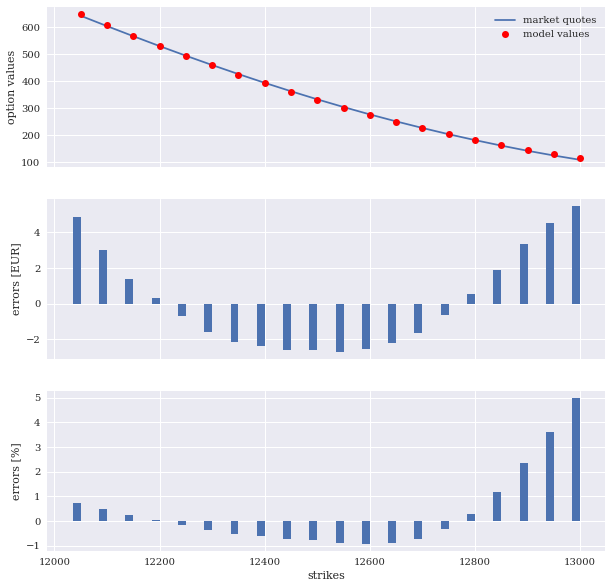

In [46]:
fix, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10, 10))
strikes = option_selection['STRIKE_PRC'].values
ax1.plot(strikes, option_selection['CF_CLOSE'], label='market quotes')
ax1.plot(strikes, option_selection['MODEL'], 'ro', label='model values')
ax1.set_ylabel('option values')
ax1.legend(loc=0)
wi = 15
ax2.bar(strikes - wi / 2., option_selection['ERRORS_EUR'], width=wi)
ax2.set_ylabel('errors [EUR]')
ax3.bar(strikes - wi / 2., option_selection['ERRORS_%'], width=wi)
ax3.set_ylabel('errors [%]')
ax3.set_xlabel('strikes');
# plt.savefig('../../images/ch21/dx_cal_04.png');

## Market-Based Valuation

### Modeling Option Positions

In [47]:
me_dax = dx.market_environment('me_dax', pricing_date)
me_dax.add_constant('initial_value', initial_value)
me_dax.add_constant('final_date', pricing_date)
me_dax.add_constant('currency', 'EUR')

In [48]:
me_dax.add_constant('volatility', opt_local[0])  
me_dax.add_constant('lambda', opt_local[1])  
me_dax.add_constant('mu', opt_local[2])  
me_dax.add_constant('delta', opt_local[3])  

In [49]:
me_dax.add_constant('model', 'jd')

In [50]:
payoff_func = 'np.maximum(strike - instrument_values, 0)'

In [51]:
shared = dx.market_environment('share', pricing_date)  
shared.add_constant('maturity', maturity)  
shared.add_constant('currency', 'EUR')  

In [52]:
option_positions = {}
option_environments = {}
for option in option_selection.index:
    option_environments[option] = dx.market_environment(
        'am_put_%d' % option, pricing_date)  
    strike = option_selection['STRIKE_PRC'].loc[option]  
    option_environments[option].add_constant('strike', strike)  
    option_environments[option].add_environment(shared)  
    option_positions['am_put_%d' % strike] = \
                    dx.derivatives_position(
                        'am_put_%d' % strike,
                        quantity=np.random.randint(10, 50),
                        underlying='dax_model',
                        mar_env=option_environments[option],
                        otype='American',
                        payoff_func=payoff_func)  

### The Options Portfolio

In [53]:
val_env = dx.market_environment('val_env', pricing_date)
val_env.add_constant('starting_date', pricing_date)
val_env.add_constant('final_date', pricing_date)  
val_env.add_curve('discount_curve', csr)
val_env.add_constant('frequency', 'B')
val_env.add_constant('paths', 25000)

In [54]:
underlyings = {'dax_model' : me_dax}  

In [55]:
portfolio = dx.derivatives_portfolio('portfolio', option_positions,
                                  val_env, underlyings)  

In [56]:
%time results = portfolio.get_statistics(fixed_seed=True)

CPU times: user 2min 6s, sys: 981 ms, total: 2min 7s
Wall time: 32 s


In [57]:
results.round(1)

,name,quant.,value,curr.,pos_value,pos_delta,pos_vega
0,am_put_12050,33,151.6,EUR,5002.8,-4.7,38206.9
1,am_put_12100,38,161.5,EUR,6138.4,-5.7,51365.2
2,am_put_12150,20,171.3,EUR,3426.8,-3.3,27894.5
3,am_put_12200,12,183.9,EUR,2206.6,-2.2,18479.7
4,am_put_12250,37,197.4,EUR,7302.8,-7.3,59423.5
5,am_put_12300,37,212.3,EUR,7853.9,-8.2,65911.9
6,am_put_12350,36,228.4,EUR,8224.1,-9.0,70969.4
7,am_put_12400,16,244.3,EUR,3908.4,-4.3,32871.4
8,am_put_12450,17,262.7,EUR,4465.6,-5.1,37451.2
9,am_put_12500,16,283.4,EUR,4534.8,-5.2,36158.2


In [58]:
results[['pos_value','pos_delta','pos_vega']].sum().round(1)

pos_value     197346.2
pos_delta       -224.0
pos_vega     1138571.1
dtype: float64

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>